# Vision Transformer

In [1]:
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [2]:
import requests

labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

print(f"labels({len(labels)}):", ", ".join(labels[:5]), "...")

labels(1000): tench, goldfish, great white shark, tiger shark, hammerhead ...


In [3]:
transform_resize = transforms.Resize(
    256, interpolation=transforms.InterpolationMode.BILINEAR
)
transform_crop = transforms.CenterCrop(224)

transform = transforms.Compose(
    [
        transform_resize,
        transform_crop,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def preprocess_image(image_path):
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)

    return input_batch


def classify_image(image_path, model):
    input_batch = preprocess_image(image_path)
    input_batch = input_batch.to(device)
    with torch.no_grad():
        output = model(input_batch)

    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

In [4]:
image_path = "dog1.jpg"
predicted_class = classify_image(image_path, model)
print(f"Predicted class: {labels[predicted_class]}")

Predicted class: Pomeranian


## Image Embedding

We split an image into fixed-size patches, linearly embed each of them.

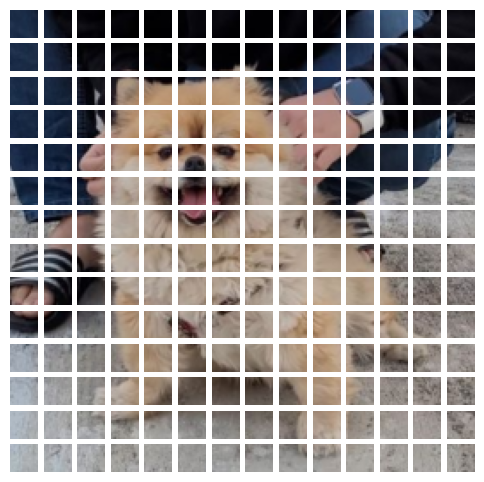

In [5]:
patch_size = 16

image = Image.open(image_path)
image = transform_resize(image)
image = transform_crop(image)

patches = []
for i in range(0, 224, patch_size):
    for j in range(0, 224, patch_size):
        box = (j, i, j + patch_size, i + patch_size)
        patch = image.crop(box)
        patches.append(patch)

fig, axes = plt.subplots(14, 14, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i])
    ax.axis("off")
plt.show()

As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN. In this hybrid model, the patch embedding projection is applied to patches extracted from a CNN feature map.

In [6]:
input_batch = preprocess_image(image_path).to(device)
patch_embeddings = []
attention_maps = []


def hook_filter(module, input, output):
    patch_embeddings.append(output)


def hook_attention(module, input, output):
    attention_maps.append(output)


filter_hook = model.conv_proj.register_forward_hook(hook_filter)
attention_hook = model.encoder.layers.register_forward_hook(hook_attention)

with torch.no_grad():
    output = model(input_batch)

filter_hook.remove()
attention_hook.remove()

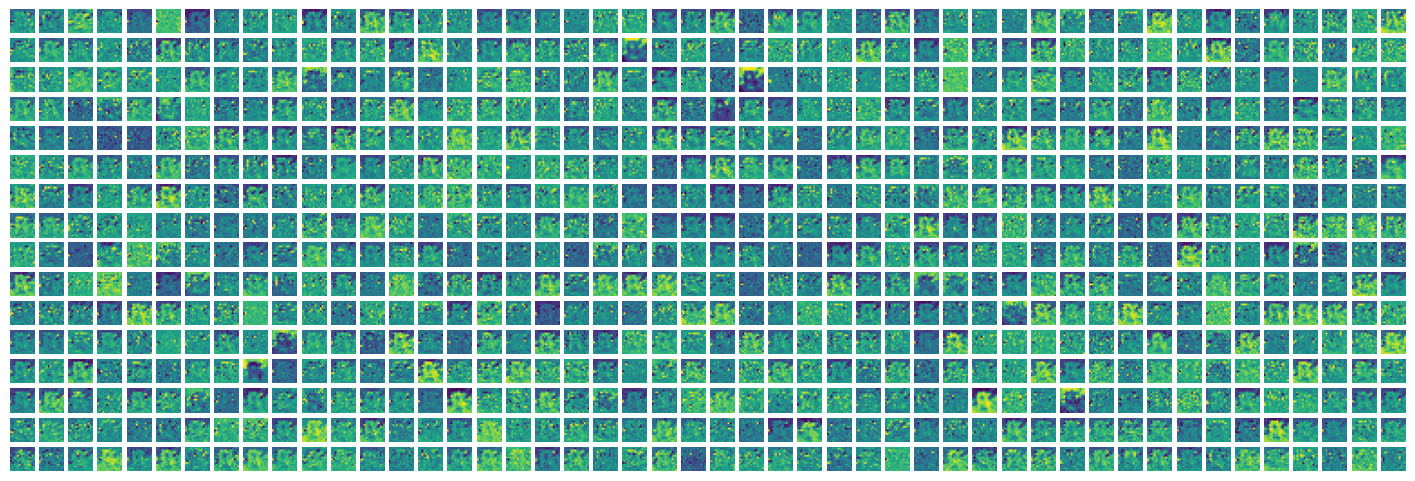

In [7]:
patch_embedding = patch_embeddings[-1].squeeze(0).cpu().numpy()

fig, axes = plt.subplots(16, 48, figsize=(18, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(patch_embedding[i, :, :])
    ax.axis("off")
plt.show()

## Positional Embedding

Tiles show the cosine similarity between the position embedding of the patch with the indicated row and column and the position embeddings of all other patches.

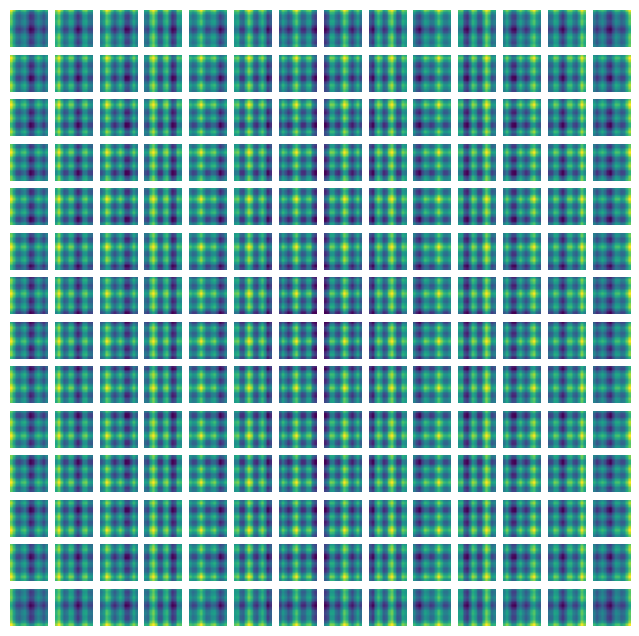

In [8]:
pos_embed = model.encoder.pos_embedding.squeeze(0)  # Shape: (197, 768)
pos_embed = pos_embed[1:, :]  # Remove CLS token
pos_embed = pos_embed.view(14, 14, -1)


def sim_patches(pos_i, pos_j):
    patches = []
    for i in range(14):
        for j in range(14):
            cos_sim = F.cosine_similarity(
                pos_embed[pos_i][pos_j], pos_embed[i][j], dim=-1
            )
            patches.append(cos_sim.detach().cpu().numpy())

    patches = np.array(patches).reshape(14, 14)
    return patches


fig, axes = plt.subplots(14, 14, figsize=(8, 8))

for row in range(14):
    for col in range(14):
        axes[row][col].imshow(sim_patches(row, col))
        axes[row][col].axis("off")

plt.show()

## Attention 

We find that the model attends to image regions that are semantically relevant for classification.

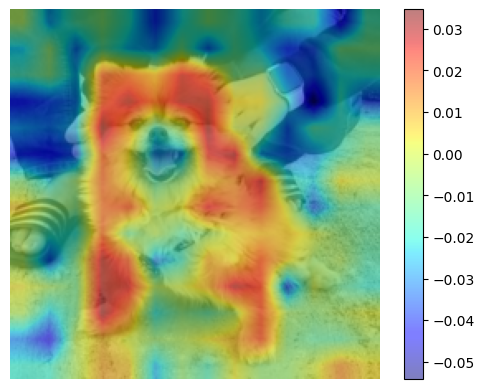

In [9]:
attention = attention_maps[-1].squeeze(0)  # Shape: (197, 768)
attention = attention.detach().cpu()[1:, :]  # Remove CLS token
attention = attention.mean(dim=-1)

attention = attention.view(14, 14)
attention = (
    np.array(
        Image.fromarray(attention.numpy() * 255).resize(
            (224, 224), resample=Image.BILINEAR
        )
    )
    / 255.0
)

plt.imshow(image)
plt.imshow(attention, cmap="jet", alpha=0.5)
plt.colorbar()
plt.axis("off")
plt.show()